**Source**: https://github.com/TripathiAshutosh/mlflow/blob/main/MLflow%20Live%20Demo.ipynb

### Create Conda environment

Run below commands in terminal but make sure conda is installed or use anaconda prompt which you will get as part of anaconda installation

1. ```conda create --prefix /Users/andreikristov/Documents/python/conda_envs/git_mlflow_demo``` it will create a conda env named envname and install python version 3.9 and a ipykernel inside this environment

2. Create a symbolic link for environment with long path (it will allow to use short env name as it is locate in default directory):

```ln -s /Users/andreikristov/Documents/python/conda_envs/git_mlflow_demo /opt/anaconda3/envs/git_mlflow_demo```

3. Activate the environment 
```conda activate "/Users/andreikristov/Downloads/(GitHub) MLflow Demo"```
or
```conda activate git_mlflow_demo``` # if it is create in one of the envs_dir

4. Install packages ```conda install python=3.9 ipykernel pandas numpy scikit-learn matplotlib seaborn mlflow notebook```

5. Install imblearn from pip:

```pip install imblearn```

(to install with pip from current conda env use abs path to pip file from that env)

If this pure command doesn't work (in my case pip from another virtual env was used, probably because its parth is in .zshrc):

```"/Users/andreikristov/Downloads/(GitHub) MLflow Demo/bin/pip" install imblearn```

6. add newly created environment to the notebook as kernel 
```python -m ipykernel install --user --name=git_mlflow_demo```

Now open the notebook using below command: (from the anaconda prompt inside conda environment)

```jupyter notebook```


In [2]:
import os
import time
import logging
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn
import scipy
from scipy.stats import uniform, randint
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.exceptions import ConvergenceWarning
from xgboost import XGBClassifier
from boruta import BorutaPy
import imblearn
import mlflow 
from mlflow import MlflowClient
import mlflow.sklearn

warnings.filterwarnings('ignore')
# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Suppress the specific warning from XGBoost
warnings.filterwarnings("ignore", message=".*use_label_encoder.*")
# Set MLflow's logger to WARNING level
logging.getLogger("mlflow").setLevel(logging.WARNING)
os.environ['MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR'] = 'false'

sns.set_style("white")
pd.set_option('display.max_columns', 100)

### Create functions

In [4]:
def load_data(path):
    data = pd.read_csv(path)
    return data

def clean_data(df, verbose=False):
    """
    _summary_

    Parameters
    ----------
    data : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    if verbose:
        print('*** data_cleaning ***')
        print("NA summary: \n")
        print(df.isna().sum())
        print("shape (before drop): ", df.shape)
    
    df = df.dropna()
    
    if verbose:
        print("after droping na values \n")
        print(df.isna().sum())
        print("shape (after drop): ", df.shape)

    return df


def preprocess_dataset(df, verbose=False):
    """
    _summary_

    Parameters
    ----------
    df : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """

    # 1. replace values 
    #   education: basic.4y, basic.6y, basic.9y to basic; '.' in the name to '_'
    #   job: 'admin.' -> 'admin'
    df['education'] = df['education'].replace(r'^basic.*', 'basic', regex=True).str.replace('.','_', regex=False)
    df['job'] = df['job'].str.replace('.','')

    features_cat = df.select_dtypes(include='object').columns.tolist()
    features_num = df.select_dtypes(include='number').columns.tolist()

    # 2. preprocess categorical features
    df_cat_preprocessed = pd.get_dummies(data=df[features_cat], dtype=int)

    # 3. preprocess numerical features (reserved)
    df_num_preprocessed = df[features_num] # placeholder, replace with meaningful processing
    
    # 4. combine preprocessed features
    df_preprocessed = pd.concat([df_num_preprocessed, df_cat_preprocessed], axis=1)
    
    # 5. fix column names (lower case, w/o [. ,])
    df_preprocessed.columns = df_preprocessed.columns.str.replace(r'[\.\s]','_', regex=True).str.lower()
    
    if verbose:
        print('*** preprocess_dataset ***')

    return df_preprocessed


def train_test_split(df, verbose=False):
    """
    _summary_

    Parameters
    ----------
    df : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """

    from sklearn.model_selection import train_test_split
    
    X = df.drop(columns='y')
    y = df[['y']]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify = y, random_state=47)
    
    if verbose:
        print('*** train_test_split ***')

    return X_train, X_test, y_train, y_test


def oversample_dataset(X, y, how='SMOT', verbose=False):
    """
    _summary_

    Parameters
    ----------
    X : _type_
        _description_
    y : _type_
        _description_
    how : str, optional
        _description_, by default 'SMOT'
    verbose : bool, optional
        _description_, by default False

    Returns
    -------
    _type_
        _description_
    """
    from imblearn.over_sampling import SMOTE, SMOTENC
    
    assert how in ['SMOTE', 'SMOTENC'], "how MUST be one of ('SMOTE', 'SMOTENC)"

    features_cat = X.select_dtypes(include='object').columns.tolist()

    if how == 'SMOTE':
        smote = SMOTE(sampling_strategy=0.5, k_neighbors=5, random_state=42)
        X_oversampled, y_oversampled = smote.fit_resample(X, y)
    elif how == 'SMOTENC':
        smote_cat = SMOTENC(categorical_features=features_cat, sampling_strategy=0.5, k_neighbors=5, random_state=42)
        X_oversampled, y_oversampled = smote_cat.fit_resample(X, y) 

    X_oversampled = pd.DataFrame(data=X_oversampled, columns=X.columns)
    y_oversampled = pd.DataFrame(data=y_oversampled, columns=['y'])
    
    if verbose:
        print('*** oversample_dataset ***')
        print("N samples (before): ",len(X))
        print("N samples (after): ", len(X_oversampled))
        print('y value counts: \n', y.value_counts())
        print('y (over sampled) value counts: \n', y_oversampled.value_counts())
 
    return X_oversampled, y_oversampled


def train_model(model, X, y, params, verbose=False):
    """
    _summary_

    Parameters
    ----------
    X_train : _type_
        _description_
    y_train : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """

    assert hasattr(model, "fit"), "Model MUST have 'fit' method."
    
    if params:
        model = model.set_params(**params)
    
    model.fit(X, y)
    
    if verbose:
        print('*** train_model ***')
    
    return model


def predict_model(model, X, y, threshold=None, verbose=False):
    """
    _summary_

    Parameters
    ----------
    model : _type_
        _description_
    X_test : _type_
        _description_
    y_test : _type_
        _description_
    threshold : _type_, optional
        _description_, by default None
    verbose : bool, optional
        _description_, by default False

    Returns
    -------
    _type_
        _description_
    """

    # assertions
    assert hasattr(model, "predict"), "Model MUST have 'predict' method."
    #assert threshold is None or 0.0 <= threshold <= 1.0 or threshold == 'optimal', "threshold MUST be None or in the range [0,1] or 'optimal'. If None - default 0.5."
    # if threshold is not None and 0.0 <= threshold <= 1.0 or threshold == 'optimal':
    #     assert hasattr(model, "predict_proba"), 'If provided threshold is in the range [0,1], model MUST have predict_proba method.'
    
    y_pred = model.predict(X)
    y_pred_proba = None
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X)[:,1]
    
        if isinstance(threshold, (int, float)) and 0.0 <= threshold <= 1.0:
            #y_pred_proba = model.predict_proba(X)[:,1]
            y_pred = (y_pred_proba > threshold).astype(int)
        elif threshold == 'optimal':
            #y_pred_proba = model.predict_proba(X)[:,1]
            threshold, _, _ = get_optimal_threshold(y_true=y, y_pred_proba=y_pred_proba, verbose=verbose)
            y_pred = (y_pred_proba > threshold).astype(int)
        elif threshold is None:
            threshold = 0.5
            y_pred = (y_pred_proba > threshold).astype(int)
        else:
            ValueError("threshold MUST be one of: None, float in the range [0,1], 'optimal'. If None - default 0.5.")


    if verbose:
        print('*** predict_model ***')
        print("predictions: \n", y_pred[:5])
        print("predictions (proba): \n", y_pred_proba[:5] if y_pred_proba is not None else None)
        print('threshold: ', threshold)
    
    return y_pred, y_pred_proba, threshold


def get_metrics(y_true, y_pred, y_pred_proba=None, verbose=True):
    """
    _summary_

    Parameters
    ----------
    model : _type_
        _description_
    X : _type_
        _description_
    y : _type_
        _description_
    threshold : _type_, optional
        _description_, by default None
    verbose : bool, optional
        _description_, by default False

    Returns
    -------
    _type_
        _description_
    """

    from sklearn.metrics import (
        accuracy_score,
        precision_score,
        recall_score,
        f1_score,
        roc_auc_score,
        matthews_corrcoef,
        confusion_matrix,
        cohen_kappa_score
    )

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    metrics = {
        'accuracy': round(acc, 2), 
        'precision': round(prec, 2), 
        'recall': round(recall, 2),
        'f1_score': round(f1, 2),
        'matthews_corrcoef': round(mcc, 2),
        'kappa': round(kappa, 2)
        }
    
    # metrics from confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['tn'] = tn
    metrics['fp'] = fp
    metrics['fn'] = fn
    metrics['tp'] = tp
    # accuracy per class
    # metrics['accuracy_p'] = np.divide(tp, (tp + fn), where=(tp + fn) != 0, out=np.nan)
    # metrics['accuracy_n'] = np.divide(tn, (tn + fp), where=(tn + fp) != 0, out=np.nan)
    metrics['accuracy_p'] = np.nan if (tp + fn) == 0 else tp / (tp + fn)
    metrics['accuracy_n'] = np.nan if (tn + fp) == 0 else tn / (tn + fp)
    
    # Calculate AUC only if probabilities are provided
    if y_pred_proba is not None:
        auc = roc_auc_score(y_true, y_pred_proba)
        metrics['auc'] = round(auc, 2)
        # manual (for comparison)
        tpr, fpr, thr = prep_roc_auc(y_true, y_pred_proba, verbose=verbose)
        roc_auc_manual = calculate_auc(fpr, tpr)
        metrics['auc_manual'] = round(roc_auc_manual, 2)
    
    if verbose:
        print('*** get_metrics ***')
        for k, v in metrics.items():
            print(f"{k}: {v}")

    return metrics

    
def get_optimal_threshold(y_true, y_pred_proba, verbose=False):
    
    tpr, fpr, thr = prep_roc_auc(y_true, y_pred_proba, verbose=verbose)
    
    # Calculate the Youden's J statistic (TPR - FPR)
    youdens_j = np.array(tpr) - np.array(fpr)
    
    # Find the index of the maximum Youden's J statistic
    optimal_idx = np.argmax(youdens_j)
    
    # Get the optimal threshold value
    optimal_threshold = thr[optimal_idx]
    
    if verbose:
        print(f"Optimal threshold: {optimal_threshold}")
        print(f"True Positive Rate (TPR) at optimal threshold: {tpr[optimal_idx]}")
        print(f"False Positive Rate (FPR) at optimal threshold: {fpr[optimal_idx]}")

    return optimal_threshold, tpr[optimal_idx], fpr[optimal_idx]

def prep_roc_auc(y_true, y_pred_proba, verbose=False):
    """
    _summary_

    Parameters
    ----------
    y : _type_
        _description_
    y_pred_prob : _type_
        _description_
    verbose : bool, optional
        _description_, by default False

    Returns
    -------
    _type_
        _description_
    """

    from sklearn.metrics import confusion_matrix
    
    thr_arr = np.arange(start=0, stop=1.1, step=0.1)
    tpr_arr = []
    fpr_arr = []

    for thr in thr_arr:
        if thr == 0:
            tpr_arr.append(1)
            fpr_arr.append(1)
        elif thr ==1:
            tpr_arr.append(0)
            fpr_arr.append(0)
        else:
        #print(thr)
            df = pd.DataFrame({'y': y_true, 'y_pred_prob': y_pred_proba})
            df['y_pred'] = np.where(df['y_pred_prob'] > thr, 1, 0)
            df['is_match'] = df['y'] == df['y_pred']
            cm = confusion_matrix(df['y'], df['y_pred'])
            tp = cm[1,1]
            fp = cm[0,1]
            tn = cm[0,0]
            fn = cm[1,0]
            tpr = tp / (tp + fn)
            fpr = fp / (fp + tn)
            #print('tpr: ', tpr)
            #print('fpr: ', fpr)
            tpr_arr.append(tpr)
            fpr_arr.append(fpr)
            #print(cm)

    if verbose:
        print('*** prep_roc_auc ***')

    return tpr_arr, fpr_arr, thr_arr

def calculate_auc(fpr, tpr, verbose=False):
    """
    _summary_

    Parameters
    ----------
    fpr : _type_
        _description_
    tpr : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """

    # insure range [0,1] for correct caculation of AUC score
    # if min(tpr) != 0:
    #     tpr.append(0)
    # if min(fpr) != 0:
    #     fpr.append(0)
    # if max(tpr) != 1:
    #     tpr.append(1)
    # if max(fpr) != 1:
    #     fpr.append(1)

    auc = 0.0
    for i in range(1, len(fpr)):
        auc += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2

    auc = np.abs(auc)

    if verbose:
        print('*** calculate_auc ***')
        print('auc: ', auc)

    return auc

def plot_roc_auc(y, y_pred_proba, type='manual', ax=None, show=True, verbose=False):
    """
    _summary_

    Parameters
    ----------
    y : _type_
        _description_
    y_pred_prob : _type_
        _description_
    type : str, optional
        Prescribes how to calculate tpr, fpr: manually or use sklearn functionality. One of the ('manual', 'sklearn')
    verbose : bool, optional
        _description_, by default False
    """

    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    if type == 'manual':
        tpr, fpr, thr = prep_roc_auc(y, y_pred_proba, verbose=verbose)
    elif type == 'sklearn':
        fpr, tpr, thr = roc_curve(y, y_pred_proba, drop_intermediate=False)

    result_df = pd.DataFrame({'thr': thr, 'tpr': tpr, 'fpr': fpr}).sort_values(by='thr')

    threshold_optimal, tpr_optimal, fpr_optimal = get_optimal_threshold(y_true=y, y_pred_proba=y_pred_proba, verbose=verbose)

    #roc_auc = auc(fpr, tpr) # give not correct value
    roc_auc_manual = calculate_auc(fpr, tpr)

    if verbose:
        print('*** create_roc_auc_plot ***')
        #print(f"AUC Score: {roc_auc:.2f}")
        print(f"AUC Score (manual): {roc_auc_manual:.2f}")
        print(result_df)

    if ax is not None:
        ax=ax
    else:
        fig, ax = plt.subplots(figsize=(8, 6))
    sns.lineplot(x='fpr', y='tpr', data=result_df, color='blue', label=f'ROC curve (AUC = {roc_auc_manual:.2f})', ax=ax)
    sns.lineplot(x=[0, 1], y=[0, 1], color='gray', linestyle='--', ax=ax)  # Diagonal line representing random chance
    sns.scatterplot(x=[fpr_optimal], y=[tpr_optimal], color='green', s=100, label='Optimal Point', ax=ax)
    ax.axvline(x=fpr_optimal, color='grey', ls=':')
    ax.annotate(text=f'optimal thr: {str(threshold_optimal)}', xy=(fpr_optimal, tpr_optimal),xytext=(fpr_optimal+0.01, tpr_optimal-0.02), fontsize=8)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('FP Rate', fontsize=10)
    ax.set_ylabel('TP Rate', fontsize=10)
    ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=12)
    ax.tick_params(axis='x', labelsize=8)  # Set x-axis tick labels size
    ax.tick_params(axis='y', labelsize=8)
    ax.legend(loc="lower right")
    plt.grid()
    plt.savefig('roc_auc_curve.png', facecolor='white', edgecolor='white')
    
    if show:
        plt.show()
    else:
        plt.close()
    

def plot_confusion_matrix(y, y_pred, ax=None, show=True, verbose=False):
    """
    _summary_

    Parameters
    ----------
    y : _type_
        _description_
    y_pred : _type_
        _description_
    """

    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    
    # 6. Generate the confusion matrix
    cm = confusion_matrix(y, y_pred)

    if verbose:
        print('*** create_confusion_matrix_plot ***')
        print('confusion matrix: \n', cm)

    # 7. Plot the confusion matrix using seaborn heatmap
    if ax is not None:
        ax=ax
    else:
        fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'], ax=ax)
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.legend()
    plt.savefig('confusion_matrix.png', facecolor='white', edgecolor='white')
    
    if show:
        plt.show()
    else:
        plt.close()


def get_feature_importance_rf(X, y, n_estimators=100, random_state=42, verbose=False):
    """
    Calculate feature importance using a Random Forest model.
    
    Parameters:
        X (pd.DataFrame): The input features.
        y (pd.Series): The target variable.
        n_estimators (int): Number of trees in the forest.
        random_state (int): Random state for reproducibility.
        
    Returns:
        pd.DataFrame: DataFrame containing features and their importance scores.
    """
    # Initialize and fit the RandomForest model
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state, n_jobs=-1)
    
    rf_model.fit(X.values, y.values.ravel())
    
    # Extract feature importances
    importances = rf_model.feature_importances_
    feature_imp_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    })
    
    if verbose:
        print('*** get_feature_importance_boruta ***')
        print('Feature importances: \n', feature_imp_df)

    # Sort by importance and return
    return feature_imp_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)


def get_feature_importance_boruta(X, y, max_iter=100, random_state=42, verbose=False):
    """
    Calculate feature importance using the Boruta method.
    
    Parameters:
        X (pd.DataFrame): The input features.
        y (pd.Series): The target variable.
        max_iter (int): Maximum number of iterations for the Boruta algorithm.
        random_state (int): Random state for reproducibility.
        
    Returns:
        pd.DataFrame: DataFrame containing features and their Boruta importance status.
    """
    # Initialize a RandomForestClassifier for use with Boruta
    rf = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=random_state)

    # Initialize Boruta feature selector
    boruta_selector = BorutaPy(
        estimator=rf,
        n_estimators='auto',
        max_iter=max_iter,
        random_state=random_state
    )
    
    # Fit the Boruta selector to the data
    boruta_selector.fit(X.values, y.values.ravel())
    
    # Get results and create a DataFrame
    feature_status = boruta_selector.support_  # True if the feature is selected
    feature_ranking = boruta_selector.ranking_  # Ranking of features
    feature_imp_df = pd.DataFrame({
        'Feature': X.columns,
        'Selected': feature_status,
        'Importance': feature_ranking
    })

    if verbose:
        print('*** get_feature_importance_boruta ***')
        print('Feature importances: \n', feature_imp_df)
    
    # Sort by ranking and return
    return feature_imp_df.query('Selected == True').sort_values(by='Importance')


def plot_feature_importances(X, y, verbose=False):
    """
    _summary_

    Parameters
    ----------
    df_feature_imp : _type_
        A dataframe with feature importances
    method : str, optional
        Method to use for calculating feature importance, by default 'rf'
    varbose : bool, optional
        _description_, by default True
    """

    df_feature_imp_rf = get_feature_importance_rf(X, y)
    df_feature_imp_boruta = get_feature_importance_boruta(X, y)

    limit = 15
    n_features_vis = max(limit, len(df_feature_imp_boruta))
    if len(df_feature_imp_rf) > n_features_vis:
            df_feature_imp_rf = df_feature_imp_rf.head(n_features_vis)

    if verbose:
        print('*** plot_feature_importance ***')
        
    
    _, (ax1, ax2) = plt.subplots(figsize=(8, 0.2 * n_features_vis), ncols=2)

    sns.barplot(y='Feature', x='Importance', data=df_feature_imp_rf, color='steelblue', ax=ax1)
    sns.barplot(y='Feature', x='Importance', color='steelblue', data=df_feature_imp_boruta, ax=ax2)

    ax1.set_title(f'Feature Importance (RF)', fontsize=12)
    ax1.set_xlabel('Importance', fontsize=10)
    ax1.set_ylabel('Feature', fontsize=10)
    ax1.tick_params(axis='x', labelsize=8)  # Set font size for x-axis ticks
    ax1.tick_params(axis='y', labelsize=8)  # Set font size for y-axis ticks

    ax2.set_title(f'Feature Importance (Boruta)', fontsize=12)
    ax2.set_xlabel('Importance', fontsize=10)
    ax2.set_ylabel('Feature', fontsize=10)
    ax2.tick_params(axis='x', labelsize=8)  # Set font size for x-axis ticks
    ax2.tick_params(axis='y', labelsize=8)  # Set font size for y-axis ticks

    plt.tight_layout()

    plt.savefig(f'feature_importances.png')
    plt.show()

    

def tune_model(model, X, y, param_grid, scoring='accuracy', verbose=False):
    """
    _summary_

    Parameters
    ----------
    model : _type_
        _description_
    X : _type_
        _description_
    y : _type_
        _description_
    param_grid : _type_
        _description_
    scoring : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """

    from sklearn.model_selection import RandomizedSearchCV

    # cast y as array
    y = y.values.ravel()

    # set number of iterations for random search (not more than 100)
    n_iter_total = 1
    n_iter_limit = 100
    for k, v in param_grid.items():
        n_iter_total *= len(v)
    n_iter = min(n_iter_limit, n_iter_total)
    
    rs = RandomizedSearchCV(
        estimator = model, 
        param_distributions = param_grid, 
        n_iter = n_iter,
        scoring=scoring,
        cv = 5, 
        verbose=False, 
        random_state=35, 
        n_jobs = -1)
    
    rs.fit(X, y)

    best_params = rs.best_params_
    
    # fit model with best params
    model_tuned = model.set_params(**best_params) 
    model_tuned.fit(X, y)

    if verbose:
        print('*** tune_model ***')
        print("# of total param combinations: ", n_iter_total)
        print("# of iterations: ", n_iter)
        print ('Param grid: \n', param_grid, '\n')
        # print the best parameters
        print ('Best Parameters: \n', best_params, ' \n')
    
    return model_tuned, best_params


def log_experiment(experiment_name, model, input_example, run_name, run_metrics, run_params=None, run_tags=None, run_artifacts_png=None, verbose=False):
    """
    _summary_

    Parameters
    ----------
    experiment_name : _type_
        _description_
    model : _type_
        _description_
    input_example : _type_
        _description_
    run_name : _type_
        _description_
    run_metrics : _type_
        _description_
    run_params : _type_, optional
        _description_, by default None
    run_tags : _type_, optional
        _description_, by default None
    run_artifacts_png : _type_, optional
        _description_, by default None
    """

    mlflow.set_experiment(experiment_name)

    client = MlflowClient()

    try:
        client.get_experiment_by_name(experiment_name)
        mlflow.set_experiment(experiment_name)
    except Exception as e:
        if verbose:
            print(f"Experiment not found: {e}")
        client.create_experiment(experiment_name)
        client.set_experiment(experiment_name)

    with mlflow.start_run(run_name=run_name) as run:
        # log metrics
        for m in run_metrics:
            mlflow.log_metric(m, run_metrics[m])
        # log model
        mlflow.sklearn.log_model(sk_model=model, artifact_path='model', input_example=input_example)
        # log params
        if run_params:
            for p in run_params.items():
                mlflow.log_param(key=p[0], value=p[1])
        # log tags
        if run_tags:
            for t in run_tags.items():
                mlflow.set_tag(key=t[0], value=t[1])
        # log artifacts
        if run_artifacts_png:
            for a in run_artifacts_png:
                if os.path.exists(a):
                    mlflow.log_artifact(a)

    if verbose:
        run_id = run.info.run_id
        experiment_id = run.info.experiment_id
        experiment = mlflow.get_experiment(experiment_id)
        # print('*** log_experiment ***')   
        # print('Run - is logged.')
        # # Get the run info
        # print(f'experiment name: {experiment.name}')
        # print(f'experiment id: {experiment.experiment_id}')
        # print('run_name: ', run.info.run_name)
        # print('run_id: ', run_id)
        print(f'experiment_id: {experiment.experiment_id}, run_id: {run_id}')
    

def plot_decision_boundary(model, X, y, remove_outliers=False, show=True, verbose=True):
    """
    Plot decision boundary for model given two dimensional input X and labels y (real or predicted)

    Parameters
    ----------
    model: a model decision boundary of which we want to draw, must have 'predict' method
    X: pd.DataFrame with two features, an input of the data model
    y: int or object or category labels (real or predicted) used for coloring scatterplot
    """
    
    assert isinstance(X, pd.DataFrame), "X has to be an instance of pandas DataFrame."
    assert X.shape[1] > 1, "X has to have at least 2 features."
    assert hasattr(model, "predict"), "The provided model doesn't have a predict method."
    
    if remove_outliers:
        # filter outliers: for that combine X and y into df (to filter y in parallel), filter by X, separate X and y
        df = pd.concat([X, pd.Series(y, name='y')], axis=1)
        q01_x1 = np.quantile(X.iloc[:, 0], 0.01)
        q99_x1 = np.quantile(X.iloc[:, 0], 0.99)
        q01_x2 = np.quantile(X.iloc[:, 1], 0.05)
        q99_x2 = np.quantile(X.iloc[:, 1], 0.99)
        df = df[(df.iloc[:, 0] > q01_x1) & (df.iloc[:, 0] < q99_x1) & (df.iloc[:, 1] > q01_x2) & (df.iloc[:, 1] < q99_x2)]
        X, y = df.drop(columns=['y']), df['y']

    hn = 100 # parameter grid coef = number of point on the whole range of the variable with equal space between them
    if X.shape[1] > 2:
        # Step 1: Reduce the dimensionality to 2D for visualization using PCA
        pca = PCA(n_components=2)
        X_reduced = pca.fit_transform(X)
        # Set min and max values and give it some padditng
        x1_min, x1_max = X_reduced[:, 0].min(), X_reduced[:, 0].max()
        x2_min, x2_max = X_reduced[:, 1].min(), X_reduced[:, 1].max()
        # Generate a grid of points with distance h between them
        xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, hn), np.linspace(x2_min, x2_max, hn))
        # Predict the function value for the whole grid
        Z = model.predict(pca.inverse_transform(np.c_[xx1.ravel(), xx2.ravel()]))
    elif X.shape[1] == 2:
        x1_min, x1_max = X.iloc[:, 0].min(), X.iloc[:, 0].max()
        x2_min, x2_max = X.iloc[:, 1].min(), X.iloc[:, 1].max()
        # Generate a grid of points with distance h between them
        xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, hn), np.linspace(x2_min, x2_max, hn))
        # Predict the function value for the whole grid
        Z = model.predict(np.c_[xx1.ravel(), xx2.ravel()])
        
    Z = Z.reshape(xx1.shape)

    if verbose:
        print('*** plot_decision_boundary ***')
        print('x1_min, x1_max: ', x1_min, x1_max)
        print('x2_min, x2_max: ', x2_min, x2_max)
    
    # Plot the contour and training examples
    fig, (ax1, ax2) = plt.subplots(figsize=(20,10), ncols=2)
    ax1.contour(xx1, xx2, Z, cmap=plt.cm.Spectral)

    if X.shape[1] > 2:
        sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y, palette='Set2', ax=ax1)
    else:
        sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='Set2', ax=ax1)

    ax = fig.add_subplot(122, projection='3d')
    ax.plot_surface(xx1, xx2, Z, cmap=plt.cm.Spectral)

    ax1.set_xlabel(X.columns[0])
    ax1.set_ylabel(X.columns[1])
    ax2.set_xlabel(X.columns[0])
    ax2.set_ylabel(X.columns[1])

    # ax1.set_xlim(x1_min, x1_max)
    # ax1.set_ylim(x2_min, x2_max)
    # ax2.set_xlim(x1_min, x1_max)
    # ax2.set_ylim(x2_min, x2_max)

    #ax1.set_aspect('equal', adjustable='box')

    plt.tight_layout()

    plt.savefig('decision_boundary.png', facecolor='white', edgecolor='white')
    
    if show:
        plt.show()
    else:
        plt.close()


def get_files_list(directory, extensions):
    """
    List all files in the specified directory (and subdirectories) with the specified extension.
    
    Args:
        directory (str): The path to the directory to search in.
        extension (str): The file extension to search for (e.g., '.txt').

    Returns:
        list: A list of paths to files with the specified extension.
    """
    files_with_extension = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(tuple(extensions)):
                files_with_extension.append(os.path.join(root, file))
    return files_with_extension


def remove_files(directory, extensions, verbose=False):
    """
    Delete all files in the provided list of file paths.
    
    Args:
        file_list (list): A list of file paths to delete.
    """
    file_list = get_files_list(directory=directory, extensions=extensions)

    cnt = 0
    for file_path in file_list:
        try:
            os.remove(file_path)
            if verbose:
                print(f"Deleted: {file_path}")
            cnt += 1
        except OSError as e:
            print(f"Error deleting {file_path}: {e}")

    if verbose:
        print(f'Deleted {cnt} files from {len(file_list)}.')

def remove_png():
    return remove_files(directory=os.getcwd(), extensions=['.png'], verbose=False)


def convert_X_preprocessed_to_dataframe(X, preprocessor):
    #X_train_preprocessed = preprocessor.fit_transform(X_train)
    columns_cat_preprocessed = preprocessor.transformers_[1][1].named_steps['encoder'].get_feature_names_out(columns_cat)
    columns_preprocessed = columns_num + list(columns_cat_preprocessed)
    return pd.DataFrame(X, columns=columns_preprocessed)


## Load and Prepare Data

In [5]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

#data = load_data('data/banking.csv')
data = pd.read_csv('data/banking.csv')
data_cleaned = clean_data(data)

X, y = data.drop(columns='y'), data[['y']]

columns_num = X.select_dtypes(include=['number']).columns.tolist()
columns_cat = X.select_dtypes(include=['object']).columns.tolist()

transformer_num = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

transformer_cat = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', transformer_num, columns_num),
    ('cat', transformer_cat, columns_cat)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# oversample dataset to fix inbalanca with SMOT
X_train_oversampled, y_train_oversampled = oversample_dataset(X_train, y_train, how='SMOTENC', verbose=False)

# check
X_train_preprocessed = preprocessor.fit_transform(X_train)
columns_cat_preprocessed = preprocessor.transformers_[1][1].named_steps['encoder'].get_feature_names_out(columns_cat)
columns_preprocessed = columns_num + list(columns_cat_preprocessed)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=columns_preprocessed)
X_train_preprocessed.head()


,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,-0.094669,0.602794,-0.570006,0.191021,-0.349548,0.839718,1.537852,-0.276872,0.717044,0.844365,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.094669,0.390231,0.160572,0.191021,-0.349548,0.648116,0.722902,0.893416,0.713579,0.329818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.001417,-0.618478,0.160572,0.191021,-0.349548,-1.204035,-0.867202,-1.425489,-1.281812,-0.944759,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.001417,-0.432968,0.160572,0.191021,-0.349548,0.839718,1.537852,-0.276872,0.763825,0.844365,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5.574418,0.053995,-0.204717,0.191021,-0.349548,-2.225911,-1.981486,2.952257,-1.671650,-2.076483,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Feature Importance

*** plot_feature_importance ***


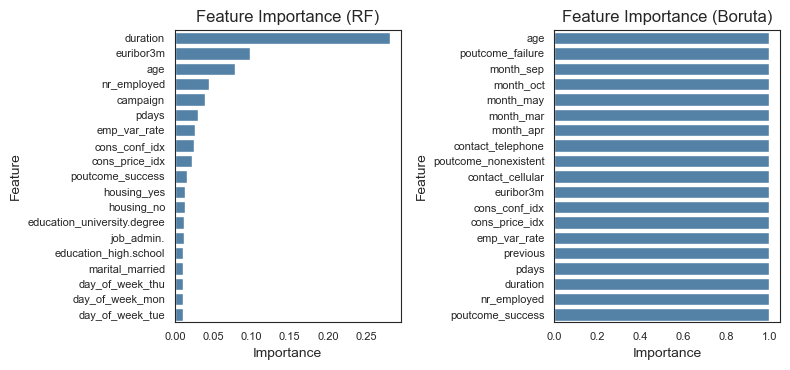

In [309]:
plot_feature_importances(X=X_train_preprocessed, y=y_train, verbose=True)

### Plot Oversampled Data

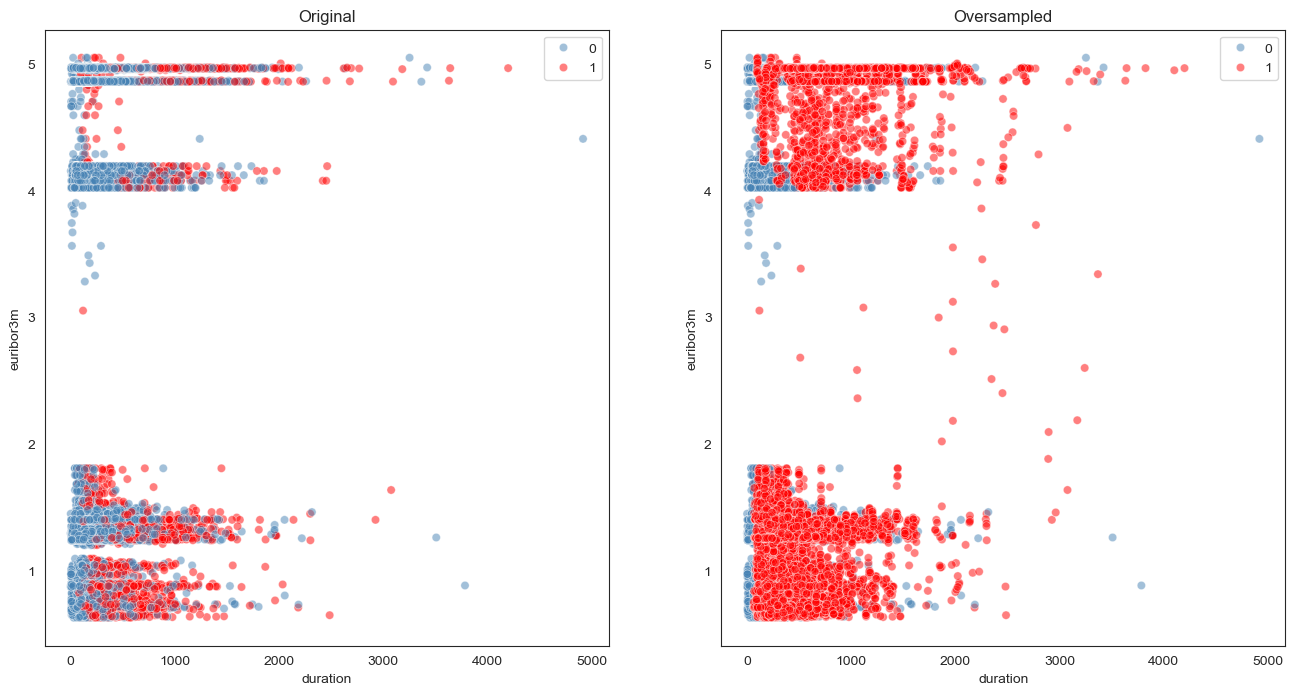

In [6]:
# variables to visualize
vars_vis = ['duration', 'euribor3m']

_, (ax1, ax2) = plt.subplots(figsize=(16,8), ncols=2)
p = {0: 'steelblue', 1: 'red'}
sns.scatterplot(data=X_train, x=vars_vis[0], y=vars_vis[1], hue=y_train.values.ravel(), color='steelblue', alpha=0.5, palette=p, ax=ax1)
sns.scatterplot(data=X_train_oversampled, x=vars_vis[0], y=vars_vis[1], hue=y_train_oversampled.values.ravel(), color='steelblue', alpha=0.5, palette=p, ax=ax2)
ax1.set_title('Original')
ax2.set_title('Oversampled')

plt.show()

## Run Experiments

Before logging experiments:
```
mlflow server --backend-store-uri ./mlruns --default-artifact-root ./mlruns --port 5000
```
If we need to clean processes on running on the port:
```
lsof -i :5000
kill -9 <PID1> <PID2> <PID3> ...

In [325]:
mlflow.set_tracking_uri("file:///Users/andreikristov/Documents/repos/ml_projects/Credit Risk (sklearn, NN, mlflow)/mlruns")

****************************************************************************************************
*** Run Model: NaiveBayes
****************************************************************************************************
run_1:  {'model_name': 'NaiveBayes', 'model_type': 'basic', 'x_type': 'original', 'thr_roc': 0.5, 'fit_time': 0.01679205894470215, 'ts': '2024_11_08_184142'}
metrics:  {'accuracy': 0.81, 'precision': 0.35, 'recall': 0.69, 'f1_score': 0.46, 'matthews_corrcoef': 0.4, 'kappa': 0.37, 'tn': 6058, 'fp': 1237, 'fn': 288, 'tp': 655, 'accuracy_p': 0.694591728525981, 'accuracy_n': 0.8304318026045237, 'auc': 0.84, 'auc_manual': 0.79}
experiment_id: 791999877004330524, run_id: b9e6354c77e84667a9f2e69c57385d49
run_2:  {'model_name': 'NaiveBayes', 'model_type': 'basic', 'x_type': 'original', 'thr_roc': 'optimal', 'fit_time': 0.01679205894470215, 'ts': '2024_11_08_184146'}
metrics:  {'accuracy': 0.79, 'precision': 0.32, 'recall': 0.76, 'f1_score': 0.45, 'matthews_corrcoef': 0.

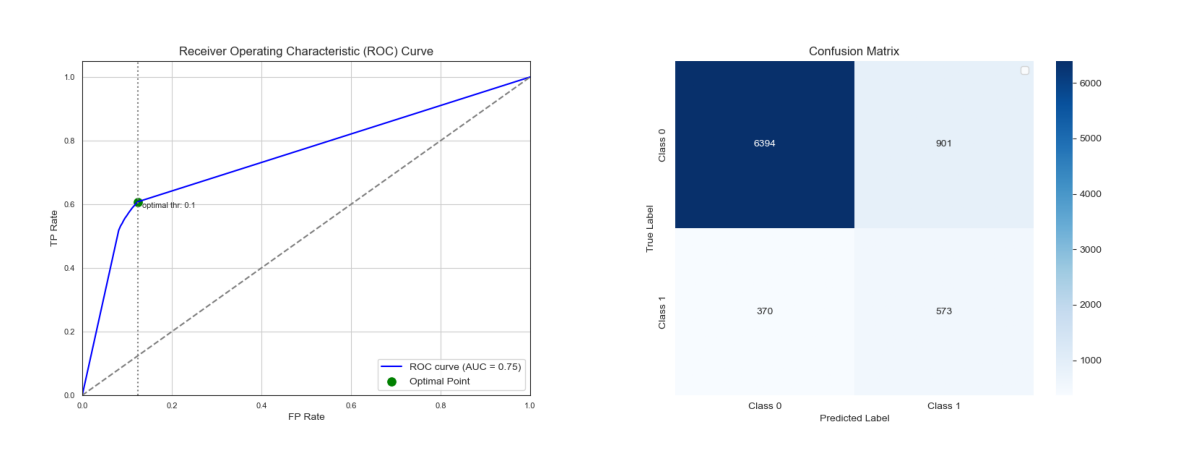

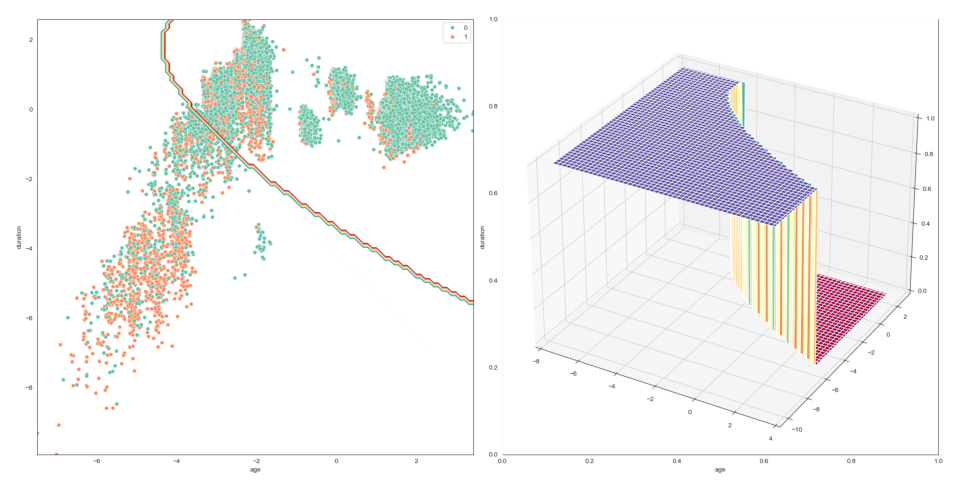

experiment_id: 952392886163561695, run_id: 2f22620d371c4442874d64a21c2c2e2c
run_3:  {'model_name': 'NaiveBayes', 'model_type': 'tuned', 'x_type': 'oversampled', 'thr_roc': 0.5, 'fit_time': 0.3278210163116455, 'ts': '2024_11_08_184204'}
metrics:  {'accuracy': 0.83, 'precision': 0.35, 'recall': 0.63, 'f1_score': 0.45, 'matthews_corrcoef': 0.38, 'kappa': 0.36, 'tn': 6211, 'fp': 1084, 'fn': 349, 'tp': 594, 'accuracy_p': 0.6299045599151644, 'accuracy_n': 0.8514050719671008, 'auc': 0.79, 'auc_manual': 0.76}
experiment_id: 952392886163561695, run_id: 46f2722171f9464093e1c2bc12b8816c
run_4:  {'model_name': 'NaiveBayes', 'model_type': 'tuned', 'x_type': 'oversampled', 'thr_roc': 'optimal', 'fit_time': 0.3278210163116455, 'ts': '2024_11_08_184208'}
metrics:  {'accuracy': 0.81, 'precision': 0.34, 'recall': 0.66, 'f1_score': 0.45, 'matthews_corrcoef': 0.38, 'kappa': 0.35, 'tn': 6061, 'fp': 1234, 'fn': 319, 'tp': 624, 'accuracy_p': 0.6617179215270413, 'accuracy_n': 0.8308430431802605, 'auc': 0.79, 

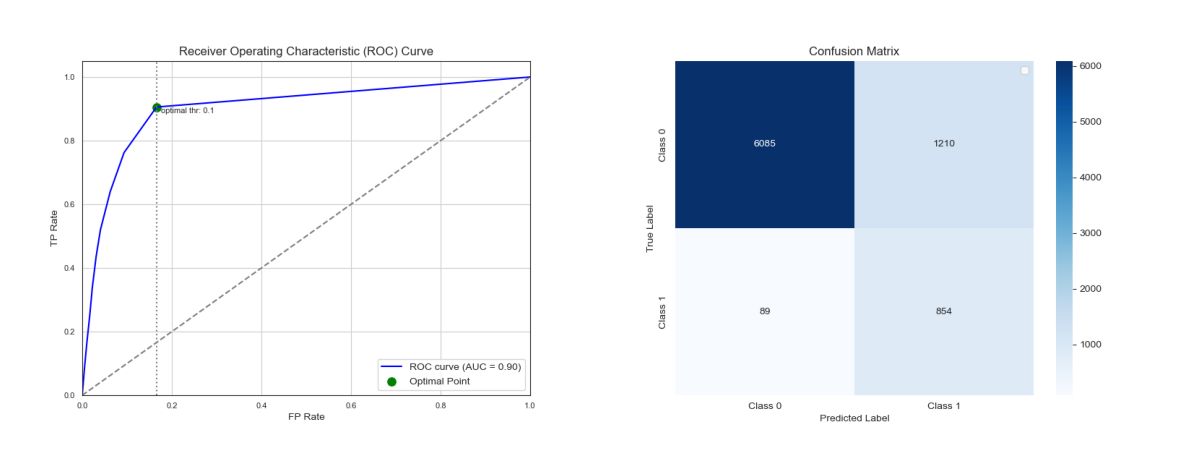

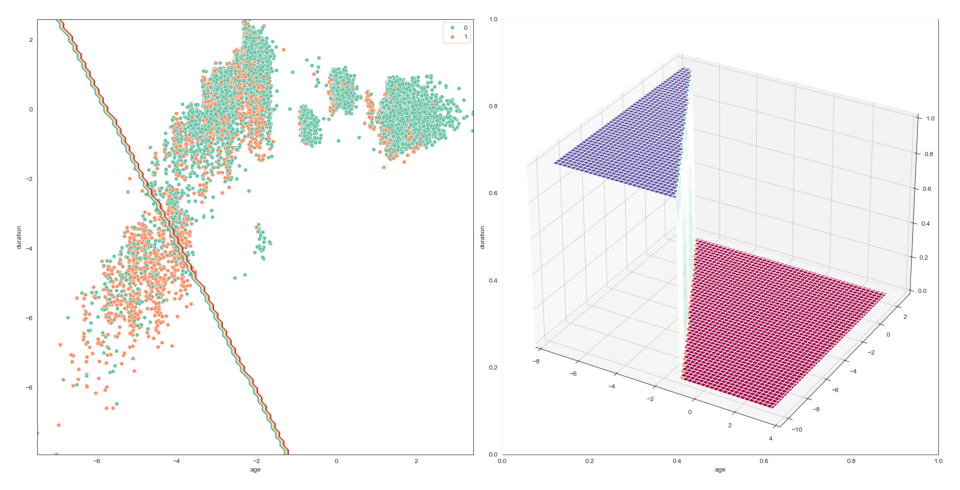

experiment_id: 459060352158224760, run_id: 75267e84b5524311b9c2d4590fcc56b7
run_3:  {'model_name': 'LogisticRegression', 'model_type': 'tuned', 'x_type': 'oversampled', 'thr_roc': 0.5, 'fit_time': 22.63001275062561, 'ts': '2024_11_08_184319'}
metrics:  {'accuracy': 0.89, 'precision': 0.52, 'recall': 0.71, 'f1_score': 0.6, 'matthews_corrcoef': 0.55, 'kappa': 0.54, 'tn': 6674, 'fp': 621, 'fn': 275, 'tp': 668, 'accuracy_p': 0.7083775185577943, 'accuracy_n': 0.9148732008224811, 'auc': 0.92, 'auc_manual': 0.91}
experiment_id: 459060352158224760, run_id: 2ef767d793f74998b5aec1c50de5baf0
run_4:  {'model_name': 'LogisticRegression', 'model_type': 'tuned', 'x_type': 'oversampled', 'thr_roc': 'optimal', 'fit_time': 22.63001275062561, 'ts': '2024_11_08_184323'}
metrics:  {'accuracy': 0.82, 'precision': 0.38, 'recall': 0.9, 'f1_score': 0.54, 'matthews_corrcoef': 0.51, 'kappa': 0.45, 'tn': 5909, 'fp': 1386, 'fn': 90, 'tp': 853, 'accuracy_p': 0.9045599151643691, 'accuracy_n': 0.8100068540095956, 'au

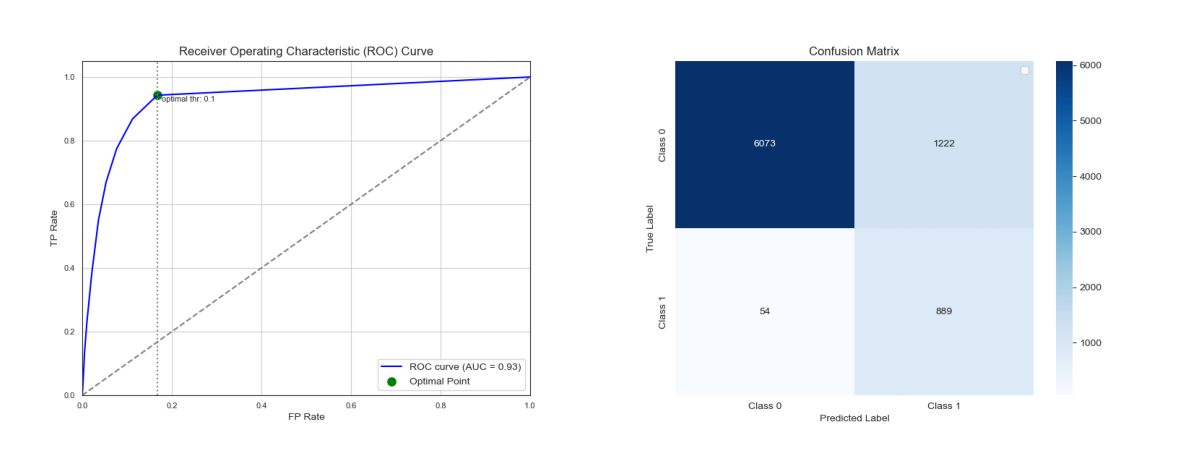

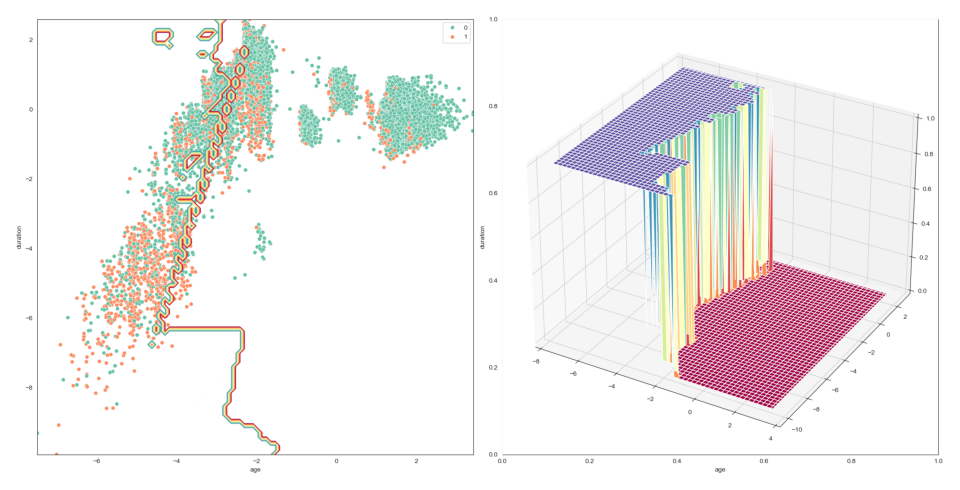

experiment_id: 577567145314630886, run_id: beee0c9655474cdda9bd25bf5d5191d5
run_3:  {'model_name': 'XGBoost', 'model_type': 'tuned', 'x_type': 'oversampled', 'thr_roc': 0.5, 'fit_time': 8.107309103012085, 'ts': '2024_11_08_184405'}
metrics:  {'accuracy': 0.9, 'precision': 0.58, 'recall': 0.61, 'f1_score': 0.59, 'matthews_corrcoef': 0.54, 'kappa': 0.54, 'tn': 6877, 'fp': 418, 'fn': 369, 'tp': 574, 'accuracy_p': 0.6086956521739131, 'accuracy_n': 0.9427004797806717, 'auc': 0.94, 'auc_manual': 0.89}
experiment_id: 577567145314630886, run_id: 621fac4fbe964d3dabafb8e7d0c6b344
run_4:  {'model_name': 'XGBoost', 'model_type': 'tuned', 'x_type': 'oversampled', 'thr_roc': 'optimal', 'fit_time': 8.107309103012085, 'ts': '2024_11_08_184409'}
metrics:  {'accuracy': 0.87, 'precision': 0.46, 'recall': 0.87, 'f1_score': 0.6, 'matthews_corrcoef': 0.57, 'kappa': 0.53, 'tn': 6320, 'fp': 975, 'fn': 123, 'tp': 820, 'accuracy_p': 0.8695652173913043, 'accuracy_n': 0.866346812885538, 'auc': 0.94, 'auc_manual':

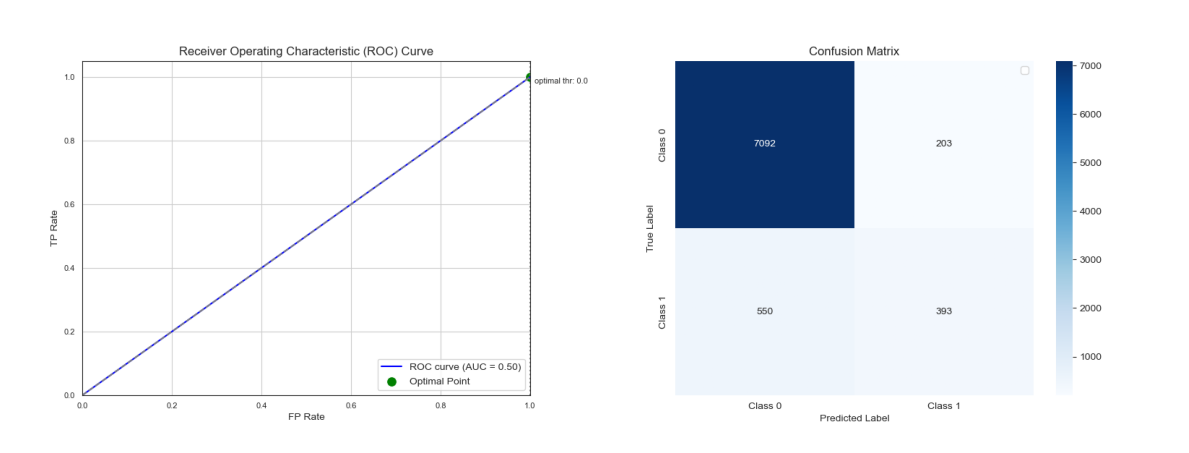

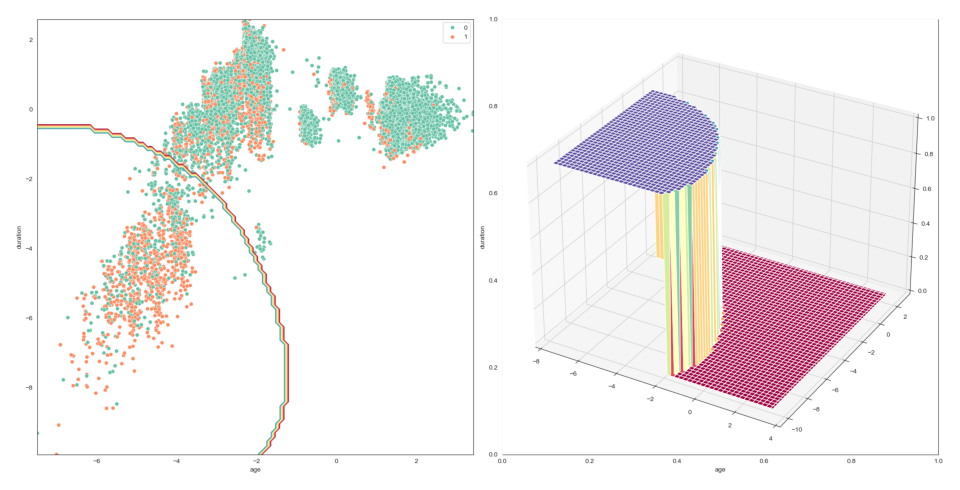

experiment_id: 648123028761442298, run_id: e5009adaad154613928172d56b57666b
run_3:  {'model_name': 'SVM', 'model_type': 'tuned', 'x_type': 'oversampled', 'thr_roc': 0.5, 'fit_time': 580.367910861969, 'ts': '2024_11_08_190052'}
metrics:  {'accuracy': 0.89, 'precision': 0.53, 'recall': 0.6, 'f1_score': 0.56, 'matthews_corrcoef': 0.5, 'kappa': 0.5, 'tn': 6784, 'fp': 511, 'fn': 373, 'tp': 570, 'accuracy_p': 0.6044538706256628, 'accuracy_n': 0.9299520219328307}
experiment_id: 648123028761442298, run_id: 76375d60a4cf4318b3b79975ad52a514
run_4:  {'model_name': 'SVM', 'model_type': 'tuned', 'x_type': 'oversampled', 'thr_roc': 'optimal', 'fit_time': 580.367910861969, 'ts': '2024_11_08_190122'}
metrics:  {'accuracy': 0.89, 'precision': 0.53, 'recall': 0.6, 'f1_score': 0.56, 'matthews_corrcoef': 0.5, 'kappa': 0.5, 'tn': 6784, 'fp': 511, 'fn': 373, 'tp': 570, 'accuracy_p': 0.6044538706256628, 'accuracy_n': 0.9299520219328307}
experiment_id: 648123028761442298, run_id: 80749a787b7c42f9b852d8a95f434

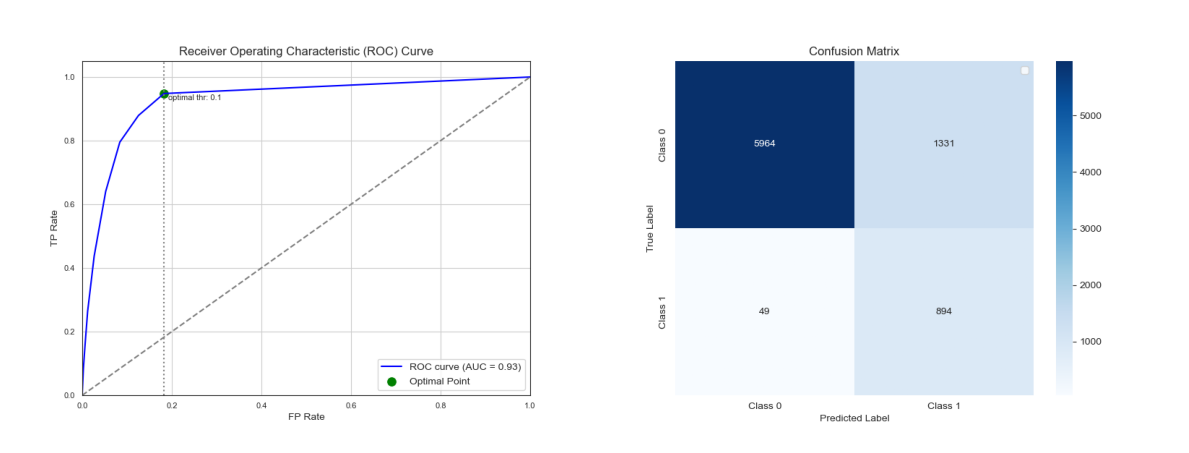

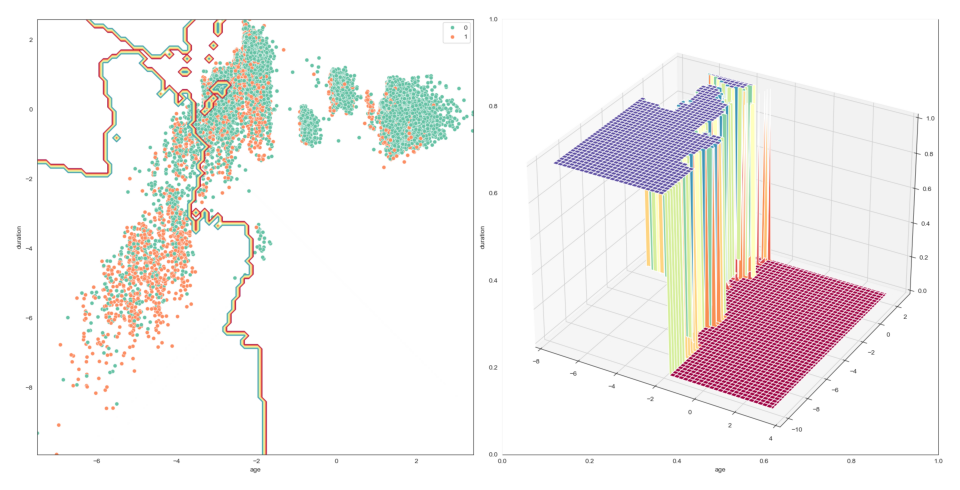

experiment_id: 601249055806676084, run_id: 8e3adca404ee4da6bbfcab36ff5e8b38
run_3:  {'model_name': 'RandomForest', 'model_type': 'tuned', 'x_type': 'oversampled', 'thr_roc': 0.5, 'fit_time': 43.48990273475647, 'ts': '2024_11_08_190315'}
metrics:  {'accuracy': 0.9, 'precision': 0.57, 'recall': 0.64, 'f1_score': 0.6, 'matthews_corrcoef': 0.55, 'kappa': 0.55, 'tn': 6849, 'fp': 446, 'fn': 343, 'tp': 600, 'accuracy_p': 0.6362672322375398, 'accuracy_n': 0.9388622344071281, 'auc': 0.94, 'auc_manual': 0.93}
experiment_id: 601249055806676084, run_id: 1380030082864f089499e2c3f0fe71b4
run_4:  {'model_name': 'RandomForest', 'model_type': 'tuned', 'x_type': 'oversampled', 'thr_roc': 'optimal', 'fit_time': 43.48990273475647, 'ts': '2024_11_08_190320'}
metrics:  {'accuracy': 0.85, 'precision': 0.42, 'recall': 0.93, 'f1_score': 0.58, 'matthews_corrcoef': 0.56, 'kappa': 0.5, 'tn': 6107, 'fp': 1188, 'fn': 69, 'tp': 874, 'accuracy_p': 0.926829268292683, 'accuracy_n': 0.8371487320082248, 'auc': 0.94, 'auc

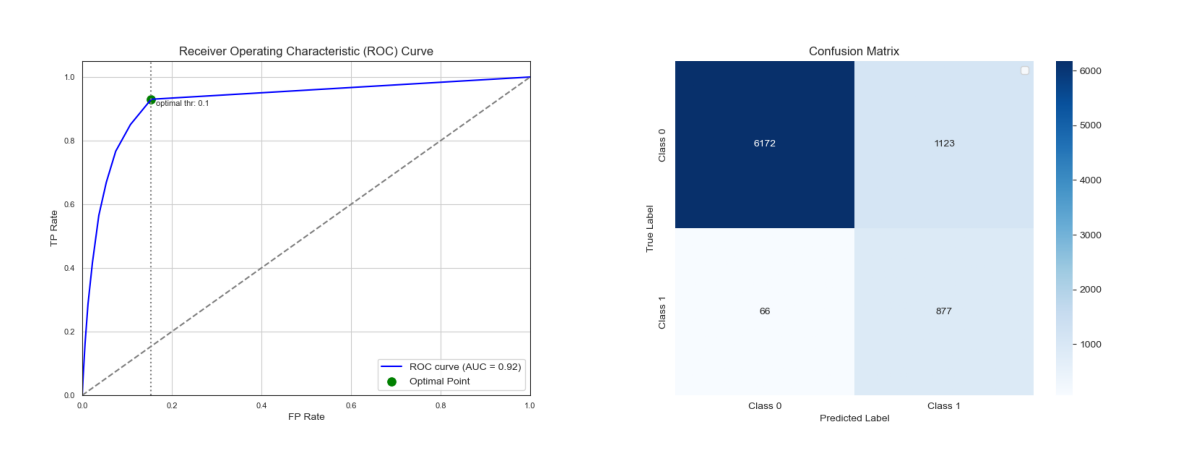

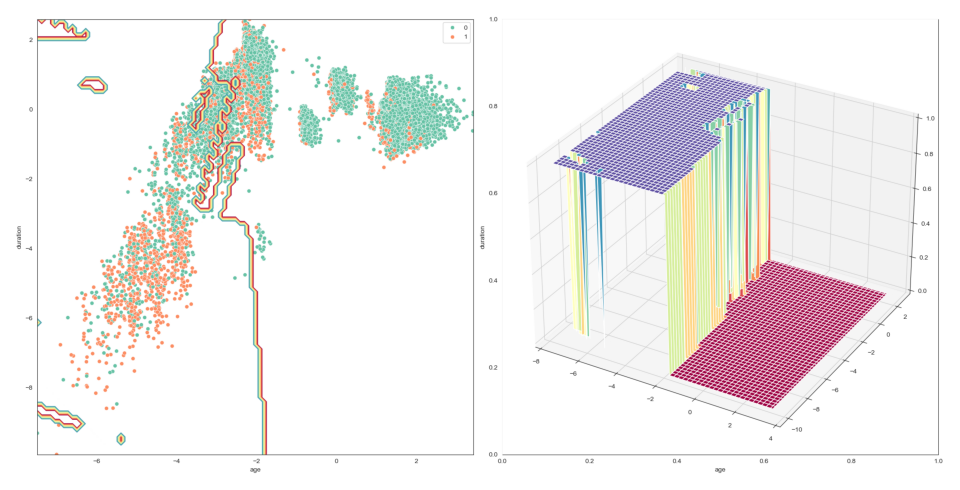

experiment_id: 193114355751151050, run_id: 7fbe65459351484cb6bd3a65b3e1e198
run_3:  {'model_name': 'GradientBoosting', 'model_type': 'tuned', 'x_type': 'oversampled', 'thr_roc': 0.5, 'fit_time': 165.32359385490417, 'ts': '2024_11_08_190838'}
metrics:  {'accuracy': 0.91, 'precision': 0.59, 'recall': 0.65, 'f1_score': 0.62, 'matthews_corrcoef': 0.57, 'kappa': 0.57, 'tn': 6870, 'fp': 425, 'fn': 331, 'tp': 612, 'accuracy_p': 0.6489925768822906, 'accuracy_n': 0.9417409184372858, 'auc': 0.94, 'auc_manual': 0.91}
experiment_id: 193114355751151050, run_id: a5696855287f4f3680c4bdfebb4aa631
run_4:  {'model_name': 'GradientBoosting', 'model_type': 'tuned', 'x_type': 'oversampled', 'thr_roc': 'optimal', 'fit_time': 165.32359385490417, 'ts': '2024_11_08_190842'}
metrics:  {'accuracy': 0.85, 'precision': 0.44, 'recall': 0.92, 'f1_score': 0.59, 'matthews_corrcoef': 0.57, 'kappa': 0.52, 'tn': 6171, 'fp': 1124, 'fn': 74, 'tp': 869, 'accuracy_p': 0.9215270413573701, 'accuracy_n': 0.84592186429061, 'auc'

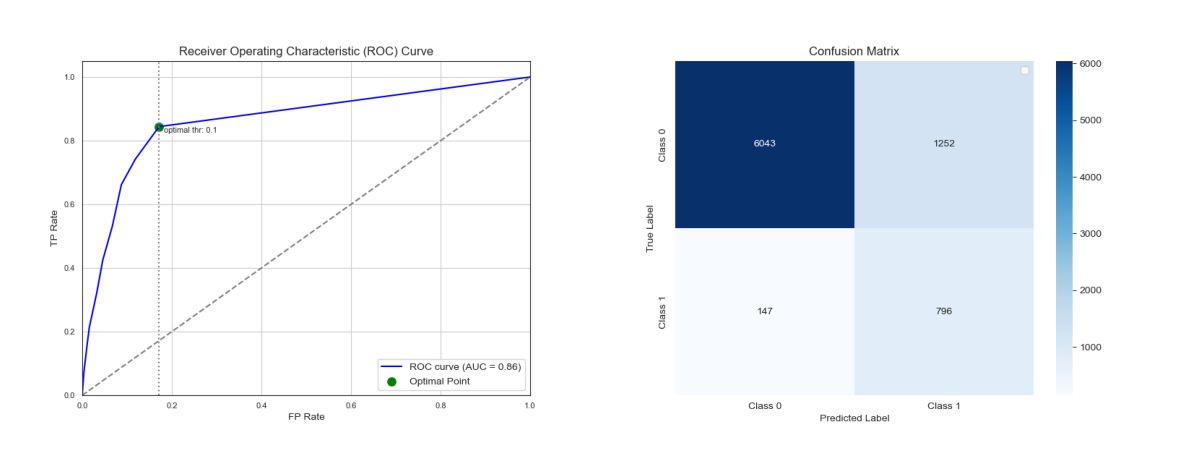

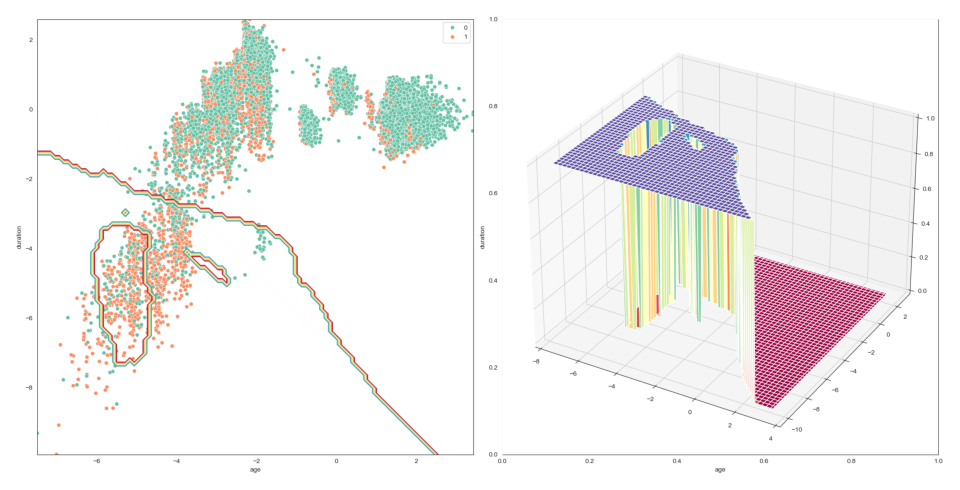

experiment_id: 967718742808142236, run_id: 3e2ce9ca27cc46cabcd42186fb58c614
run_3:  {'model_name': 'KNeighbors', 'model_type': 'tuned', 'x_type': 'oversampled', 'thr_roc': 0.5, 'fit_time': 113.6017758846283, 'ts': '2024_11_08_191226'}
metrics:  {'accuracy': 0.88, 'precision': 0.48, 'recall': 0.64, 'f1_score': 0.55, 'matthews_corrcoef': 0.49, 'kappa': 0.49, 'tn': 6649, 'fp': 646, 'fn': 336, 'tp': 607, 'accuracy_p': 0.6436903499469777, 'accuracy_n': 0.9114461960246745, 'auc': 0.88, 'auc_manual': 0.88}
experiment_id: 967718742808142236, run_id: c24e373ac49f4586b1e0b05fcda9912d
run_4:  {'model_name': 'KNeighbors', 'model_type': 'tuned', 'x_type': 'oversampled', 'thr_roc': 'optimal', 'fit_time': 113.6017758846283, 'ts': '2024_11_08_191232'}
metrics:  {'accuracy': 0.79, 'precision': 0.35, 'recall': 0.9, 'f1_score': 0.5, 'matthews_corrcoef': 0.47, 'kappa': 0.4, 'tn': 5696, 'fp': 1599, 'fn': 97, 'tp': 846, 'accuracy_p': 0.897136797454931, 'accuracy_n': 0.7808087731322824, 'auc': 0.88, 'auc_man

In [10]:
# Define the models
models = {
    'NaiveBayes': GaussianNB(),
    'LogisticRegression': LogisticRegression(solver='liblinear'),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'SVM': SVC(),
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'KNeighbors': KNeighborsClassifier()
}

# Define the parameter grids for RandomizedSearchCV
param_grids = {
    'NaiveBayes': {
        'naivebayes__var_smoothing': [1e-9, 1e-6, 1e-3]  # Three values for var_smoothing
    },
    'LogisticRegression': {
        'logisticregression__C': [0.1, 1, 10],  # Three values for regularization strength
        'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],  # Three values for penalty
        'logisticregression__solver': ['liblinear', 'saga', 'newton-cg'],  # Three solvers for optimization
        'logisticregression__max_iter': [1000] #[100, 200, 300]  # Three values for max_iter
    },
    'XGBoost': {
        'xgboost__n_estimators': [50, 100, 200],  # Three values for number of estimators
        'xgboost__learning_rate': [0.01, 0.1, 0.3],  # Three values for learning rate
        'xgboost__max_depth': [3, 5, 7],  # Three values for max depth of trees
        'xgboost__min_child_weight': [1, 3, 5],  # Three values for min child weight
        'xgboost__subsample': [0.7, 0.8, 1],  # Three values for subsample ratio
        'xgboost__colsample_bytree': [0.7, 0.8, 1],  # Three values for column subsample ratio
        'xgboost__gamma': [0, 0.1, 0.2]  # Three values for gamma regularization term
    },
    'SVM': {
        'svm__C': [0.5, 1, 10],  # Three values for regularization parameter
        'svm__kernel': ['linear', 'rbf', 'poly'],  # Three kernel types
        'svm__gamma': ['scale', 'auto', 0.1],  # Three options for gamma
        'svm__degree': [2, 3, 5]  # Three values for degree in polynomial kernel
    },
    'RandomForest': {
        'randomforest__n_estimators': [50, 100, 200],  # Three values for number of trees
        'randomforest__max_depth': [None, 10, 20],  # Three values for max depth of trees
        'randomforest__min_samples_split': [2, 5, 10],  # Three values for min samples to split
        'randomforest__min_samples_leaf': [2, 5, 10],  # Three values for min samples in leaf
        'randomforest__bootstrap': [True, False]  # Whether to use bootstrap sampling
    },
    'GradientBoosting': {
        'gradientboosting__n_estimators': [50, 100, 200],  # Three values for number of trees
        'gradientboosting__learning_rate': [0.01, 0.1, 0.3],  # Three values for learning rate
        'gradientboosting__max_depth': [3, 5, 7],  # Three values for max depth of trees
        'gradientboosting__subsample': [0.7, 0.8, 1],  # Three values for subsample ratio
        'gradientboosting__min_samples_split': [2, 5, 10]  # Three values for min samples to split
    },
    'KNeighbors': {
        'kneighbors__n_neighbors': [3, 5, 7],  # Three values for number of neighbors
        'kneighbors__weights': ['uniform', 'distance'],  # Three options for weights
        'kneighbors__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Four algorithm types
        'kneighbors__p': [1, 2]  # Manhattan (p=1) or Euclidean (p=2) distance
    }
}

def visualize_artifacts():
    import matplotlib.image as mpimg
                     
    # Load the images
    img1 = mpimg.imread('roc_auc_curve.png')  
    img2 = mpimg.imread('confusion_matrix.png') 
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
    # Display images on each subplot
    ax1.imshow(img1)
    ax1.axis('off')  
    ax2.imshow(img2)
    ax2.axis('off')
    # Show the plot
    plt.tight_layout()
    plt.show()
    img3 = mpimg.imread('decision_boundary.png')  
    # Create a figure with two subplots
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 5))
    # Display images on each subplot
    ax.imshow(img3)
    ax.axis('off')  # Turn off axis for the first image
    # Show the plot
    plt.tight_layout()
    plt.show()

# 1. Loop over each model
# for exp_id, (model_name, model) in tqdm(enumerate(models.items()), total=len(models), desc="Training Models"):
#for exp_id, (model_name, model) in tqdm(enumerate(models.items()), disable=True):
for exp_id, (model_name, model) in enumerate(models.items()):
 
    print('*'*100)
    print(f'*** Run Model: {model_name}')
    print('*'*100)

    remove_png()
    
    # 2. Loop over model type
    for model_type in ['basic', 'tuned']:

        run_id = 0

        # 3. Loop over dataset type
        for x_type in ['original', 'oversampled']:

            # apply preprocessor (do it separately outside of the main pipeline to be able to make 
            # dimensionality reduction for plotting decision boundary, in case when preprocessing and 
            # model fit are in the same pipeline we need for prediction raw data, but for PCA - preprocessed 
            # (with numeric features only), after applying PCA for prediction we need convert PCA 
            # components to the original features and RAW for feeding into pipeline.. it's a problem)
            if x_type == 'original':
                X_train_ = preprocessor.fit_transform(X_train)
                X_train_ = convert_X_preprocessed_to_dataframe(X_train_, preprocessor)
                X_test_ = preprocessor.transform(X_test)
                X_test_ = convert_X_preprocessed_to_dataframe(X_test_, preprocessor)
                y_train_ = y_train
            elif x_type == 'oversampled':
                X_train_ = preprocessor.fit_transform(X_train_oversampled)
                X_train_ = convert_X_preprocessed_to_dataframe(X_train_, preprocessor)
                X_test_ = preprocessor.transform(X_test)
                X_test_ = convert_X_preprocessed_to_dataframe(X_test_, preprocessor)
                y_train_ = y_train_oversampled

            start_time = time.time()
            if model_type == 'basic':
                pipeline = Pipeline(steps=[
                    #('preprocessor', preprocessor),
                    (model_name.lower(), model)])
                # Train the model without tuning (basic model)
                pipeline.fit(X_train_, y_train_.values.ravel())
            elif model_type == 'tuned':
                pipeline_raw = Pipeline(steps=[
                    #('preprocessor', preprocessor),
                    (model_name.lower(), model)])
                # Set up RandomizedSearchCV
                rs = RandomizedSearchCV(
                    pipeline_raw, 
                    param_distributions=param_grids[model_name], 
                    n_iter=10, 
                    scoring='accuracy', 
                    cv=5, 
                    random_state=42, 
                    n_jobs=-1
                )
                rs.fit(X_train_, y_train_.values.ravel())
                pipeline = rs.best_estimator_
            end_time = time.time()
            
            params = pipeline.named_steps[model_name.lower()].get_params()

            # 4. Loop over thresholds
            is_plot_show = True
            for thr in [0.5, 'optimal']:

                threshold_roc_auc = thr
                
                y_pred, y_pred_proba, threshold_roc_auc = predict_model(model=pipeline, X=X_test_, y=y_test.values.ravel(), threshold=threshold_roc_auc, verbose=False)
                metrics = get_metrics(y_true=y_test.values.ravel(), y_pred=y_pred, y_pred_proba=y_pred_proba, verbose=False)

                plot_roc_auc(y_test.to_numpy().flatten(), y_pred_proba, verbose=False, show=False, ax=None)
                plot_confusion_matrix(y_test.to_numpy().flatten(), y_pred, verbose=False, show=False, ax=None)
                plot_decision_boundary(model=pipeline, X=X_train_, y=y_train_.values.ravel(), remove_outliers=False, show=False, verbose=False)

                run_params = {
                        'model_name': model_name,
                        'model_type': model_type, 
                        'x_type': x_type,
                        'thr_roc': thr,
                        'fit_time': end_time - start_time,
                        'ts': datetime.now().strftime('%Y_%m_%d_%H%M%S')}
                
                run_id += 1

                # print some logs
                print(f'run_{run_id}: ', run_params)
                print('metrics: ', metrics)
                if thr == 'optimal' and model_type == 'tuned' and x_type == 'original':
                    visualize_artifacts()
                
                # print(f'exp__{model_name}_{model_type}')
                # print(f'run_{run_id:02d}__x_{x_type}__thr_{thr}')
                
                # # 5 Log experiment
                log_experiment(
                    experiment_name = f'exp__{model_name}_{model_type}', 
                    run_name = f"run_{run_id:02d}__x_{x_type}__thr_{str(thr).replace('.','')}", 
                    #run_name = 'run_01__model_default_params__x_train_original',
                    model = pipeline.named_steps[model_name.lower()], 
                    run_metrics = metrics, 
                    run_params = run_params,
                    run_tags = {},
                    input_example = X_train_.sample(n=100), 
                    run_artifacts_png = get_files_list(directory=os.getcwd(), extensions=['.png']),
                    verbose=True)
                #print('-'*30)
        

## Analysys of experiments/runs

In [502]:
[c.replace('metrics.', '') if c.startswith('metrics.') else c for c in mlflow_results.columns]
#mlflow_results

['model_name',
 'run_name',
 'accuracy',
 'accuracy_n',
 'accuracy_p',
 'auc',
 'auc_manual',
 'f1_score',
 'kappa',
 'matthews_corrcoef',
 'precision',
 'recall',
 'params.fit_time',
 'params.model_type',
 'params.x_type',
 'params.ts',
 'params.thr_roc',
 'run_id',
 'experiment_id']

In [11]:
from matplotlib.colors import LinearSegmentedColormap

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
mlflow_results = mlflow.search_runs(search_all_experiments=True)
mlflow_results = mlflow_results[
    ['params.model_name']
    + ['tags.mlflow.runName'] 
    + sorted([c for c in mlflow_results.columns if c.startswith('metrics') if c not in ['metrics.tp', 'metrics.tn', 'metrics.fp', 'metrics.fn']]) 
    + ['params.fit_time']
    + [c for c in mlflow_results.columns if c.startswith('params') if c not in ['params.model_name', 'params.fit_time']] 
    #+ [c for c in mlflow_results.columns if c.startswith('tags') and c not in ['tags.mlflow.log-model.history', 'tags.mlflow.source.name']]  
    + ['run_id', 'experiment_id']
    #+ ['status', 'artifact_uri', 'start_time', 'end_time']
    ]
mlflow_results.rename({'tags.mlflow.runName': 'run_name', 'params.model_name': 'model_name'}, inplace=True, axis=1)
mlflow_results = mlflow_results.astype({'params.fit_time': float})
mlflow_results = mlflow_results.sort_values(by=['model_name', 'run_name'])
mlflow_results.columns = [c.replace('metrics.', '') if c.startswith('metrics.') else c for c in mlflow_results.columns]

mlflow_results = mlflow_results.sort_values(by='recall', ascending=False)#.query('`params.thr_roc` == "optimal"')

# style output table
orange_cmap = LinearSegmentedColormap.from_list("orange_cmap", ["#ffffff", "#F9CB9C"])
# Define a custom color map from green to white to red
green_red_cmap = LinearSegmentedColormap.from_list("green_red_cmap", ["#A5D8A5", '#FFFFFF', "#F7A7A7"]) # , green-yellow-red ["#A5D8A5", "#F9E79F", "#F7A7A7"]


mlflow_results[mlflow_results.select_dtypes(include='float64').columns] = mlflow_results[mlflow_results.select_dtypes(include='float64').columns].round(3)


# Select only numeric columns
numeric_columns = mlflow_results.select_dtypes(include="number").columns

import matplotlib.colors as mcolors
# Function to apply color gradient with custom midpoint
def fit_time_gradient(val):
    if pd.isna(val):
        return 'background-color: lightgrey; color: black'
    # Normalize the value with the median as midpoint
    norm = mcolors.TwoSlopeNorm(vmin=mlflow_results["params.fit_time"].min(), vcenter=mlflow_results["params.fit_time"].median(), vmax=mlflow_results["params.fit_time"].max())
    color = green_red_cmap(norm(val))
    return f'background-color: {mcolors.to_hex(color)}; color: black'

# Apply background gradient to numeric columns
mlflow_results_styled = (mlflow_results.style
                         .format({col: '{:,.3f}' for col in mlflow_results.select_dtypes(include='float').columns})
                         .set_properties(**{'background-color': 'white'})  # Set whole background to white
                         .set_table_styles([
                             {'selector': 'thead th', 'props': [('background-color', 'white'), ('color', 'black')]},  # Header background
                             {'selector': 'th.row_heading', 'props': [('background-color', 'white')]},  # Index column background
                             {'selector': 'td.col0', 'props': [('text-align', 'left')]},
                             {'selector': 'td.col1', 'props': [('text-align', 'left')]}])
                         .background_gradient(cmap=orange_cmap, subset=numeric_columns)
                         #.background_gradient(cmap=green_red_cmap, subset=["params.fit_time"], vmin=mlflow_results["params.fit_time"].min(), vmax=mlflow_results["params.fit_time"].max(), midpoint=mlflow_results["params.fit_time"].median())
                         .applymap(fit_time_gradient, subset=["params.fit_time"])  # Custom gradient for "fit_time"
                         .applymap(lambda x: 'background-color: #dddddd' if pd.isna(x) else '', subset=numeric_columns)  # Set light grey for NA
                         .set_properties(**{'color': 'black'})
                        )



mlflow_results_styled

,model_name,run_name,accuracy,accuracy_n,accuracy_p,auc,auc_manual,f1_score,kappa,matthews_corrcoef,precision,recall,params.fit_time,params.thr_roc,params.x_type,params.ts,params.model_type,run_id,experiment_id
18,RandomForest,run_02__x_original__thr_optimal,0.830,0.818,0.948,0.950,0.930,0.560,0.480,0.550,0.400,0.950,30.986,optimal,original,2024_11_08_190227,tuned,8e3adca404ee4da6bbfcab36ff5e8b38,601249055806676084
22,RandomForest,run_02__x_original__thr_optimal,0.840,0.823,0.936,0.940,0.920,0.570,0.480,0.550,0.410,0.940,2.477,optimal,original,2024_11_08_190133,basic,c80840ab2e7041bbaed14c5432516084,614048567253503773
34,XGBoost,run_02__x_original__thr_optimal,0.850,0.832,0.943,0.950,0.930,0.580,0.500,0.570,0.420,0.940,6.077,optimal,original,2024_11_08_184352,tuned,beee0c9655474cdda9bd25bf5d5191d5,577567145314630886
36,XGBoost,run_04__x_oversampled__thr_optimal,0.850,0.837,0.934,0.940,0.920,0.580,0.510,0.570,0.430,0.930,0.479,optimal,oversampled,2024_11_08_184339,basic,23fdf7619b4e4643bd51f109f4f2d430,531021868981821410
16,RandomForest,run_04__x_oversampled__thr_optimal,0.850,0.837,0.927,0.940,0.930,0.580,0.500,0.560,0.420,0.930,43.490,optimal,oversampled,2024_11_08_190320,tuned,c0e84114e28d490ba19f8f110c408dea,601249055806676084
10,GradientBoosting,run_02__x_original__thr_optimal,0.860,0.846,0.930,0.950,0.920,0.600,0.520,0.580,0.440,0.930,111.558,optimal,original,2024_11_08_190548,tuned,7fbe65459351484cb6bd3a65b3e1e198,193114355751151050
12,GradientBoosting,run_04__x_oversampled__thr_optimal,0.840,0.830,0.922,0.940,0.930,0.570,0.490,0.550,0.410,0.920,7.840,optimal,oversampled,2024_11_08_190349,basic,8747cc3643554133873579786b0cf7e0,109683614847405675
14,GradientBoosting,run_02__x_original__thr_optimal,0.850,0.841,0.925,0.950,0.920,0.590,0.510,0.570,0.430,0.920,5.270,optimal,original,2024_11_08_190333,basic,1d029982ac4e4b79b00375312655768b,109683614847405675
8,GradientBoosting,run_04__x_oversampled__thr_optimal,0.850,0.846,0.922,0.940,0.910,0.590,0.520,0.570,0.440,0.920,165.324,optimal,oversampled,2024_11_08_190842,tuned,2ec4ffc704b44adfa673acecfd999716,193114355751151050
46,LogisticRegression,run_02__x_original__thr_optimal,0.840,0.834,0.906,0.930,0.900,0.570,0.490,0.540,0.410,0.910,0.155,optimal,original,2024_11_08_184215,basic,1ba633b570c540938854fdced979b724,702717189444543093


### Experiment: let's build simple NN for binary classification

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Assuming X_train and y_train are your training features and target labels

# Build the neural network model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),  # First hidden layer (64 neurons)
    Dense(32, activation='relu'),  # Second hidden layer (32 neurons)
    Dense(1, activation='sigmoid')  # Output layer (1 neuron for binary classification)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),  # Adam optimizer with learning rate 0.001
              loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
              metrics=['accuracy'])  # Track accuracy

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping])  # Apply early stopping

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Make predictions (if needed)
predictions = model.predict(X_test)


### Ad-hoc

<Axes: >

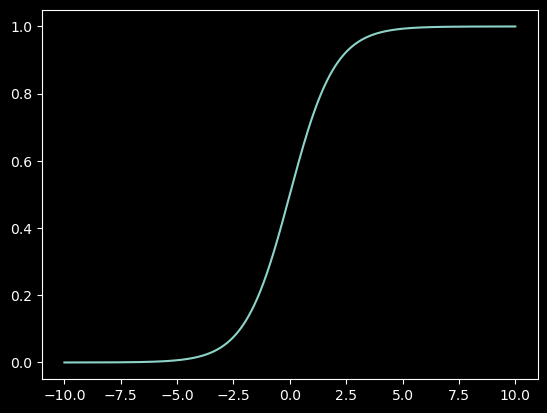

In [280]:
import seaborn as sns
x = np.linspace(-10,10, num=1000)
y = np.exp(x) / (1 + np.exp(x))
sns.lineplot(x=x,y=y)

In [11]:
# unify column names
df = pd.DataFrame({'Abs Cde': [1,2,3], 'drt': [4,5,6], 'dfg_tyu': [7,0,9]})
df.columns = df.columns.str.replace(r'[\.\s]','_', regex=True).str.lower()
df

,abs_cde,drt,dfg_tyu
0,1,4,7
1,2,5,0
2,3,6,9


In [259]:
# unpack dictionary
d = {'model_type': 'Random Forest', 'desc': 'baseline'}
#d=None
print(type(d))
if d:
    for item in d.items():
        print(item[0], item[1])
        #print(item.key(), item.value())

    for item in d:
        print(type(item))
        print(item)
        print(d[item])
        #print(item[0], item[1])

TypeError: 'str' object is not callable

In [ ]:
# set function args with dictionary
params = {'n_estimators': 100, 'max_depth': 5}
def f(n_estimators, max_depth):
    print(n_estimators, max_depth)
f(**params)

In [12]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Parameters for generating data
num_entries = 5
start_date = datetime(2024, 10, 12)
date_list = [start_date + timedelta(days=np.random.randint(1, 15)) for _ in range(num_entries)]

# Generating fake data
data = {
    'Date': [date.strftime('%Y%m%d') for date in date_list],
    'Users': np.random.randint(75000, 100500, num_entries),
    'ARPU': np.round(np.random.uniform(85, 125, num_entries), 2)
}

# Create DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)


       Date  Users    ARPU
0  20241020  77244   88.55
1  20241016  97024  112.74
2  20241021  87593  104.97
3  20241023  90102   93.69
4  20241023  89108   97.47


In [14]:
sigma = round(df['ARPU'].std(), 2)  # Calculate the standard deviation of the 'ARPU' column
n = df['Users'].sum()  # Calculate the total number of users
print('n: ', n)
def mde(sigma, n):
    return 4 * sigma / np.sqrt(n)

mde_value = mde(sigma, n)

print(f'what MDE can be detected: {mde_value * 100:.2f}%')

n:  441071
what MDE can be detected: 5.74%


In [16]:
np.random.uniform(85, 125, num_entries)
[start_date + timedelta(days=np.random.randint(1, 15)) for _ in range(num_entries)]

[datetime.datetime(2024, 10, 14, 0, 0),
 datetime.datetime(2024, 10, 24, 0, 0),
 datetime.datetime(2024, 10, 14, 0, 0),
 datetime.datetime(2024, 10, 22, 0, 0),
 datetime.datetime(2024, 10, 23, 0, 0)]